<a href="https://colab.research.google.com/github/torikulislamoli/Thesis-code-MM/blob/main/thesis_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [377]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [378]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [379]:
#DIRECTORY = r'C:\Users\Mamun\Documents\ML Data Analysis\Cats-Vs-Dog'
DIRECTORY = '/content/drive/MyDrive/bangla'
CATEGORIES = ['aids', 'allergies','diabetes','diarrhea','drug_reaction']
print(DIRECTORY)
print(os.listdir(DIRECTORY))

/content/drive/MyDrive/bangla
['diarrhea', 'allergies', 'aids', 'diabetes', 'drug_reaction']


In [380]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  22.1M      0  0:00:37  0:00:37 --:--:-- 23.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7469  100  7469    0     0   260k      0 --:--:-- --:--:-- --:--:--  260k


In [381]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2022-07-18 05:16:29.463486: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO:tensorflow:Assets written to: text_module/assets
I0718 05:16:48.063490 139778646013824 builder_impl.py:780] Assets written to: text_module/assets


In [383]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

In [384]:
embedding_layer(['এলার্জি', 'তৃষ্ণা_বৃদ্ধি_পাওয়া', 'স্পটিং_ প্রস্রাব', 'মাউথ_আলসার', 'ওজন_কমে_যাওয়া'])

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[-0.0416    ,  0.08      ,  0.0962    , ...,  0.0291    ,
         0.0124    , -0.0673    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02064752,  0.00176777, -0.04030509, ...,  0.02241528,
         0.02390021,  0.00219203],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])>

In [403]:
file_paths = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)

    for i, dir in enumerate(CATEGORIES):
      file_names = ["/".join([path, name]) for name in os.listdir(path)]
      file_paths += file_names
      labels += [i] * len(os.listdir(path))

np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

print(len(file_paths))
print(len(labels))

25
25


In [406]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)
print(train_size)

20


In [407]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [408]:
def make_datasets(train_size):
  batch_size = 10

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size] 
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train_ds, test_ds

In [409]:
train_data, validation_data = make_datasets(train_size)

## Model

In [411]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model  

In [412]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [413]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
2/2 [==============================] - 1s 170ms/step - loss: 1.6102 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/5
2/2 [==============================] - 0s 31ms/step - loss: 1.6104 - accuracy: 0.2000 - val_loss: 1.6101 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 0s 31ms/step - loss: 1.6096 - accuracy: 0.2500 - val_loss: 1.6107 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 0s 33ms/step - loss: 1.6093 - accuracy: 0.2500 - val_loss: 1.6113 - val_accuracy: 0.0000e+00


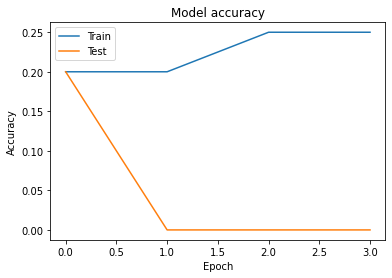

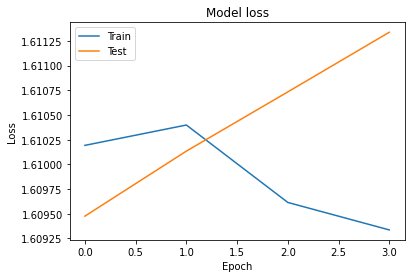

In [414]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [415]:
y_pred = model.predict(validation_data)

In [416]:
y_pred = np.argmax(y_pred, axis=1)

In [417]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[5])
  print("Predicted Class: ", CATEGORIES[y_pred[i]])
  print()
  f.close()

হাঁচি,নাক_অথবা_গলা_চুলকায়,ভরাট_নাক,কাশি
True Class:  allergies
Predicted Class:  diarrhea

বমি_বমি_ভাব,তৃষ্ণা_বৃদ্ধি_পাওয়া,পেট_ব্যথা,ওজন_কমে_যাওয়া
True Class:  diarrhea
Predicted Class:  diarrhea

মাত্রাতিরিক্ত_জ্বর,শরীরে র‍্যাশ,ক্লান্তি,মাউথ_আলসার
True Class:  aids
Predicted Class:  diarrhea



In [418]:
y_true = np.array(labels[train_size:])

5
5
5


In [419]:
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

               precision    recall  f1-score   support

         aids       0.00      0.00      0.00       1.0
    allergies       0.00      0.00      0.00       1.0
     diabetes       0.00      0.00      0.00       1.0
     diarrhea       0.00      0.00      0.00       0.0
drug_reaction       0.00      0.00      0.00       2.0

     accuracy                           0.00       5.0
    macro avg       0.00      0.00      0.00       5.0
 weighted avg       0.00      0.00      0.00       5.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1